This notebook goes over how to plot the GHI output from single OptWRF model realizations for both WRF and ERA5

Last Updated Oct 7, 2020

In [2]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Plotting functions start here -----------------------------------------------------------------------

In [3]:
def create_plot(cart_proj, plot_var, fmt_var, lats, lons, title_str='', hourly= False, save_fig=False, fig_path='./plot'):
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Make the countour lines for filled contours for the GHI
    if hourly:
        contour_levels = np.linspace(0, 0.75, 22)
    else:
        contour_levels = np.linspace(0, 5, 22)
    plt.contourf(to_np(lons), to_np(lats), to_np(plot_var), contour_levels,
                 transform=cart_proj,
                 cmap=get_cmap("hot_r"))

    # Format the plot
    format_plot(fmt_var, ax, title_str)

    # Save the figure(s)
    if save_fig:
        if hourly:
            plt.savefig(fig_path + '.png', dpi=300, transparent=True, bbox_inches='tight')
        else:
            plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')

In [4]:
def format_plot(lim_var, ax, title_str=''):
    
    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    bounds = wrf.util.geo_bounds(lim_var)
    ax.set_xlim([bounds.bottom_left.lon, bounds.top_right.lon])
    ax.set_ylim([bounds.bottom_left.lat, bounds.top_right.lat])
#     ax.set_extent(wrf.util.geo_bounds(lim_var))

    # Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")
    
    # Add the axis title
    plt.title(title_str)

## -----------------------------------------------------------------------------------------------------

In [5]:
# Verbose setting
verbose = True

# Define the datestr and paramstr
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the original wrfout data (to use wrf-python I need the format from here)
wrffile_orig = os.path.join(optwrf_abspath, 'data', wrffile_name_orig)
wrfdata_orig = netCDF4.Dataset(wrffile_orig)
if verbose:
    print(f'Original WRF DATA:\n{wrfdata_orig}\n')

# Open the processed wrfout data
wrffile = os.path.join(optwrf_abspath, 'data', wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
erafile = os.path.join(optwrf_abspath, 'data', 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Original WRF DATA:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2011-12-13_00:00:00
    SIMULATION_START_DATE: 2011-12-13_00:00:00
    WEST-EAST_GRID_DIMENSION: 192
    SOUTH-NORTH_GRID_DIMENSION: 192
    BOTTOM-TOP_GRID_DIMENSION: 36
    DX: 12000.0
    DY: 12000.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 19
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 7
    BL_PBL_PHYSICS: 8
    CU_PHYSICS: 99
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 

In [6]:
# Rename the lat-lon corrdinates to get wrf-python to recognize them
variables = {
             'lat': 'XLAT',
             'lon': 'XLONG',
            }
try:
    wrfdata = xr.Dataset.rename(wrfdata, variables)
except ValueError:
    print(f'Variables {variables} cannot be renamed, ' 
          f'those on the left are not in this dataset.')
wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 ...

In [7]:
# This makes it easy to get the latitude and longitude coordinates with the wrf-python function below
lats, lons = latlon_coords(wrfdata.ghi)

In [8]:
lats

<xarray.DataArray 'XLAT' (south_north: 191, west_east: 191)>
array([[30.952759, 30.950832, 30.948757, ..., 28.050678, 28.022198, 27.99358 ],
       [31.060238, 31.058304, 31.056229, ..., 28.153461, 28.124924, 28.096264],
       [31.16774 , 31.165806, 31.163723, ..., 28.256256, 28.227665, 28.19897 ],
       ...,
       [51.229244, 51.22667 , 51.223907, ..., 47.38171 , 47.34407 , 47.306286],
       [51.33512 , 51.332554, 51.329792, ..., 47.48225 , 47.44457 , 47.406715],
       [51.44096 , 51.438396, 51.435627, ..., 47.58274 , 47.54501 , 47.507103]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -95.43335 -95.308044 ... -64.11832
    XLAT     (south_north, west_east) float32 30.952759 30.950832 ... 47.507103
Dimensions without coordinates: south_north, west_east

In [9]:
# I have to do this tedious string parsing below to get the projection from the processed wrfout file.
try:
    wrf_proj_params = wrfdata.dni.attrs['projection']
except AttributeError:
    raise ValueError("Variable does not contain projection information")
wrf_proj_params = wrf_proj_params.replace('(', ', ')
wrf_proj_params = wrf_proj_params.replace(')', '')
wrf_proj_params = wrf_proj_params.split(',')
print(wrf_proj_params)
wrf_proj = wrf_proj_params[0]
stand_lon = float(wrf_proj_params[1].split('=')[1])
moad_cen_lat = float(wrf_proj_params[2].split('=')[1])
truelat1 = float(wrf_proj_params[3].split('=')[1])
truelat2 = float(wrf_proj_params[4].split('=')[1])
pole_lat = float(wrf_proj_params[5].split('=')[1])
pole_lon = float(wrf_proj_params[6].split('=')[1])

['LambertConformal', ' stand_lon=-97.0', ' moad_cen_lat=40.25984573364258', ' truelat1=33.0', ' truelat2=45.0', ' pole_lat=90.0', ' pole_lon=0.0']


In [66]:
# Fortunately, it still apppears to work.
if wrf_proj == 'LambertConformal':
    wrf_cartopy_proj = ccrs.LambertConformal(
                                            central_longitude=stand_lon,
                                            central_latitude=moad_cen_lat,
#                                             standard_parallels=[truelat1, truelat2],
                                            )
else: 
    print('Check yourself...')
wrf_cartopy_proj

In [68]:
vars(wrf_cartopy_proj)

{'globe': <cartopy._crs.Globe at 0x118a56f10>,
 'cutoff': -30,
 '_boundary': <shapely.geometry.polygon.LinearRing at 0x118a56ed0>,
 '_x_limits': (-17567847.747323327, 17567847.747323327),
 '_y_limits': (-9879523.685275933, 14692649.328155663),
 '_domain': <shapely.geometry.polygon.Polygon at 0x11b57f550>}

In [11]:
# We can simply use a Plate Carree projection for ERA5
era5_cartopy_proj = ccrs.PlateCarree()
era5_cartopy_proj

In [12]:
# Format the times for title slides
times_strings_f = wrfdata.Time.dt.strftime('%b %d, %Y %H:%M')

In [13]:
# Define the time indicies from the times variable
time_indicies = range(0, len(wrfdata.Time))
# Format the times for title slides
times_strings_f = wrfdata.Time.dt.strftime('%b %d, %Y %H:%M')
# Get the desired variable(s)
hourly=True
timestr = wrfdata.Time[15].values
timestr_f = times_strings_f[15].values
if hourly:
    title_str = f'Global Horizontal Irradiance (kW m-2)\n{timestr_f} (UTC)'
else:
    time_string_f = wrfdata.Time[0].dt.strftime('%b %d, %Y')
    title_str = f'Global Horizontal Irradiance (kWh m-2 day-1) \n{time_string_f.values}'

# WRF GHI
if not hourly and 15 != 0:
    wrfghi = wrfghi + (wrfdata.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000)
else:
    wrfghi = wrfdata.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000

In [14]:
dni_orig = getvar(wrfdata_orig, "SWDDNI", timeidx=15)
# Get the cartopy mapping object
wrf_cartopy_proj = get_cartopy(dni_orig)

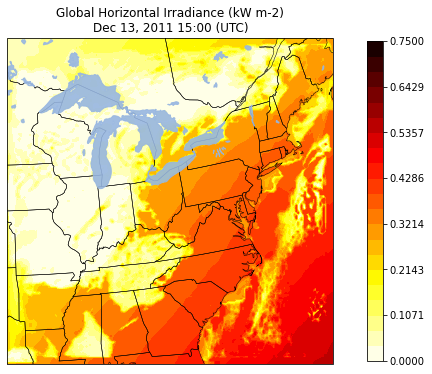

In [89]:
# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=wrf_cartopy_proj)

# Set the map bounds
ax.set_xlim(cartopy_xlim(dni_orig))
ax.set_ylim(cartopy_ylim(dni_orig))

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

# Make the countour lines for filled contours for the GHI
if hourly:
    contour_levels = np.linspace(0, 0.75, 22)
else:
    contour_levels = np.linspace(0, 5, 22)
cn = ax.contourf(to_np(lons), to_np(lats), to_np(wrfghi), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(cn, ax=ax, shrink=.98)

# Add the axis title
plt.title(title_str)
plt.show()

In [17]:
# ERA5 GHI
if not hourly and 15 != 0:
    era5ghi = era5ghi + (eradata.GHI.sel(Time=timestr_f) / 1000)
else:
    era5ghi = eradata.GHI.sel(Time=timestr_f) / 1000

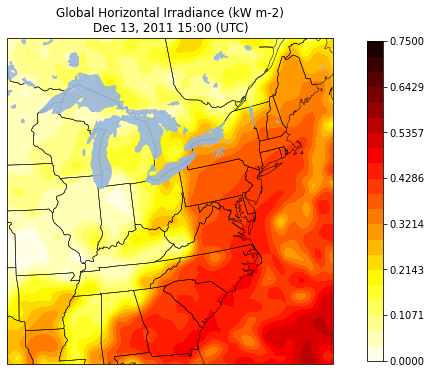

In [80]:
# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=wrf_cartopy_proj)

# Set the map bounds
ax.set_xlim(cartopy_xlim(dni_orig))
ax.set_ylim(cartopy_ylim(dni_orig))

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

# Make the countour lines for filled contours for the GHI
if hourly:
    contour_levels = np.linspace(0, 0.75, 22)
else:
    contour_levels = np.linspace(0, 5, 22)
plt.contourf(to_np(eradata.longitude), to_np(eradata.latitude), to_np(era5ghi), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Add the axis title
plt.title(title_str)
plt.show()

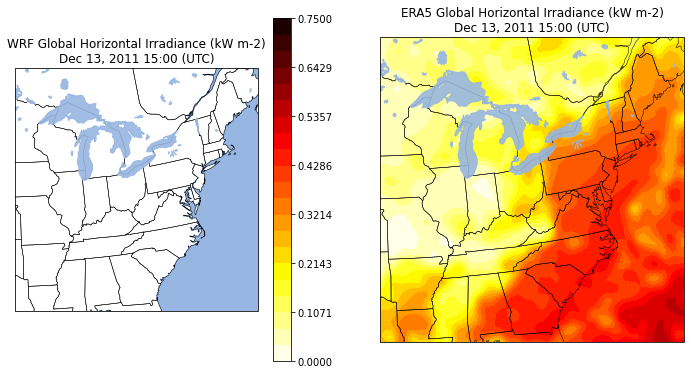

In [93]:
# Now combine the two figures...
fig = plt.figure(figsize=(12,9))
ax_wrf = fig.add_subplot(1,2,1, projection=wrf_cartopy_proj)
ax_era5 = fig.add_subplot(1,2,2, projection=wrf_cartopy_proj, sharex=ax_wrf, sharey=ax_wrf)

# Set the map bounds
ax_wrf.set_xlim(cartopy_xlim(dni_orig))
ax_wrf.set_ylim(cartopy_ylim(dni_orig))
ax_era5.set_xlim(cartopy_xlim(dni_orig))
ax_era5.set_ylim(cartopy_ylim(dni_orig))

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax_wrf.add_feature(states, linewidth=.5, edgecolor="black")
ax_wrf.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_wrf.add_feature(cfeature.OCEAN.with_scale('50m'))
ax_era5.add_feature(states, linewidth=.5, edgecolor="black")
ax_era5.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_era5.add_feature(cfeature.OCEAN.with_scale('50m'))

# Format the countour lines for filled contours for the GHI
if hourly:
    contour_levels = np.linspace(0, 0.75, 22)
else:
    contour_levels = np.linspace(0, 5, 22)

# Add the GHI filled contours
wrf_cn = ax_wrf.contourf(to_np(lats), to_np(lons), to_np(wrfghi), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

era5_cn = ax_era5.contourf(to_np(eradata.longitude), to_np(eradata.latitude), to_np(era5ghi), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

# Add a color bar
cb = plt.colorbar(wrf_cn, ax=ax_wrf, shrink=.7)

# Add the axis title
ax_wrf.set_title('WRF ' + title_str)
ax_era5.set_title('ERA5 ' + title_str)

plt.show()

## Below are the plotting functions

In [27]:
def plot_daily_GHI(wrfdat, wrfdat_orig, hourly=False, save_fig=False, fig_path='./'):
    # Define the time indicies from the times variable
    time_indicies = range(0, len(wrfdat.Time))
    # Format the times for title slides
    times_strings_f = wrfdat.Time.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        timestr = wrfdat.Time[tidx].values
        timestr_f = times_strings_f[tidx].values
        if hourly:
            title_str = f'Global Horizontal Irradiance (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = wrfdat.Time[0].dt.strftime('%b %d, %Y')
            title_str = f'Global Horizontal Irradiance (kWh m-2 day-1) \n{time_string_f.values}'
        
        if not hourly and tidx != 0:
            dni = dni + wrfdat.dni.sel(Time=np.datetime_as_string(timestr))
            ghi = ghi + (wrfdat.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000)
        else:
            dni = wrfdat.dni.sel(Time=np.datetime_as_string(timestr))
            ghi = wrfdat.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000
            
        # Get a variable from the unprocessed WRF file so we can get lats, lons, and map projection.
        # Would have been nice to think about this before post-processing...
        dni_orig = getvar(wrfdat_orig, "SWDDNI", timeidx=tidx)
        
        # Get the latitude and longitude points
        lats, lons = latlon_coords(dni_orig)

        # Get the cartopy mapping object
        try:
            wrf_proj = wrfdat.dni.attrs['projection']
        except AttributeError:
            raise ValueError("Variable does not contain projection information")
        
        if hourly:
            fig_path_temp = fig_path + str(tidx).zfill(2)
            create_plot(wrf_proj, ghi, dni_orig, lats, lons, title_str, hourly, save_fig, fig_path_temp)
    if not hourly:
        create_plot(wrf_proj, ghi, dni_orig, lats, lons, title_str, hourly, save_fig, fig_path)